In [1]:
import findspark
import matplotlib.pyplot as plt
findspark.init()
findspark.find()
import pyspark
findspark.find()

'D:\\spark-2.4.6-bin-hadoop2.7'

In [2]:
from pyspark import SparkContext, SparkConf
import numpy as np
import pandas as pd
from pyspark.sql.functions import mean , stddev, col, to_date, date_format
import pyspark.sql.functions as F
from time import strptime
import datetime
from ast import literal_eval


from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark=SparkSession(sc)

In [3]:
#Part a : 1)
a = ["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda","parallel","partition"]

new_a=map(lambda x: (x[1],x[0]), enumerate(a))
new_b=map(lambda x: (x[1],x[0]), enumerate(b))
rdd_a=sc.parallelize(new_a) 
rdd_b=sc.parallelize(new_b)
rightOuterJoin = rdd_a.leftOuterJoin(rdd_b).collect()
fullOuterJoin = rdd_a.fullOuterJoin(rdd_b).collect()

In [4]:
rightOuterJoin

[('python', (2, None)),
 ('class', (5, None)),
 ('spark', (0, None)),
 ('rdd', (1, None)),
 ('context', (3, None)),
 ('create', (4, None))]

In [5]:
fullOuterJoin

[('python', (2, None)),
 ('class', (5, None)),
 ('scala', (None, 2)),
 ('parallel', (None, 4)),
 ('partition', (None, 5)),
 ('spark', (0, None)),
 ('rdd', (1, None)),
 ('context', (3, None)),
 ('create', (4, None)),
 ('operation', (None, 0)),
 ('apache', (None, 1)),
 ('lambda', (None, 3))]

In [6]:
#Part a : 2)
rdd_a=sc.parallelize(a) 
rdd_b=sc.parallelize(b)
rdd_a.union(rdd_b).flatMap(lambda x: x).filter(lambda x: x == 's').map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).collect()

[('s', 4)]

In [7]:
#Part a : 3)
rdd_a.union(rdd_b).flatMap(lambda x: x).filter(lambda x: x == 's').aggregate(0,(lambda i, value: i + 1),(lambda i, j: (i + j)))

4

Part B

In [8]:
students_data= sc.textFile('E:\DDA\Exercise_8\students.json').collect()

In [10]:
df = spark.read.json(sc.parallelize(students_data))
#df.show(truncate=False)

In [11]:
mean_value = df.select(mean(col('points')).alias('mean') ).collect()[0]['mean']
new_df = df.fillna({'points':mean_value})
new_df.show()

+------------------+------------------+----------+---------+------------------+----+
|            course|               dob|first_name|last_name|            points|s_id|
+------------------+------------------+----------+---------+------------------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|              10.0|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|              17.0|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|              16.0|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|              12.0|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|              11.0|   5|
|          Business|  17 February 1981| Christian|   Kiriam|              10.0|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|              14.0|   7|
|     Deep Learning|  January 13, 1978|      John|     null|              10.0|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|     

In [12]:
new_df = new_df.fillna({'dob':"unknown"})
new_df = new_df.fillna({'last_name':"--"})
new_df.show()

+------------------+------------------+----------+---------+------------------+----+
|            course|               dob|first_name|last_name|            points|s_id|
+------------------+------------------+----------+---------+------------------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|              10.0|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|              17.0|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|              16.0|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|              12.0|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|              11.0|   5|
|          Business|  17 February 1981| Christian|   Kiriam|              10.0|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|              14.0|   7|
|     Deep Learning|  January 13, 1978|      John|       --|              10.0|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|     

In [14]:
from pyspark.sql.types import StringType
def change_date(dob_col):
    months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
    days= np.arange(1,32)
    if(dob_col != "unknown"):
        date_formatted =  ','.join(dob_col.split()).replace(",,",",").split(",")
        updated_date_formatted = ["","",""]
        for x in date_formatted:
            if(x in days.astype(str)):
                updated_date_formatted[0] = x.zfill(2)
            elif(x in months):
                updated_date_formatted[1] = str(strptime(x,'%B').tm_mon).zfill(2)
            else:
                updated_date_formatted[2] = x
        return '-'.join(updated_date_formatted)
    else:
        return dob_col

udfsomefunc = F.udf(change_date, StringType())
df_with_change_date = new_df.withColumn("dob", udfsomefunc("dob"))
df_with_change_date.show()

+------------------+----------+----------+---------+------------------+----+
|            course|       dob|first_name|last_name|            points|s_id|
+------------------+----------+----------+---------+------------------+----+
|Humanities and Art|14-10-1983|      Alan|      Joe|              10.0|   1|
|  Computer Science|26-09-1980|    Martin|  Genberg|              17.0|   2|
|    Graphic Design|12-06-1982|     Athur|   Watson|              16.0|   3|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|              12.0|   4|
|        Psychology|01-11-1978|      Kira| Schommer|              11.0|   5|
|          Business|17-02-1981| Christian|   Kiriam|              10.0|   6|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|              14.0|   7|
|     Deep Learning|13-01-1978|      John|       --|              10.0|   8|
|  Machine Learning|26-12-1989|    Marcus|   Carson|              15.0|   9|
|           Physics|30-12-1987|     Marta|   Brooks|              11.0|  10|

In [15]:
def calculate_age(date_col):
    if(date_col != "unknown"):
        age=pd.to_datetime(datetime.date.today()) - pd.to_datetime(date_col)
        return age.days // 365
    else:
        return date_col

udfsomefunc = F.udf(calculate_age, StringType())
df_with_age = df_with_change_date.withColumn("age", udfsomefunc("dob"))
df_with_age.show()

+------------------+----------+----------+---------+------------------+----+-------+
|            course|       dob|first_name|last_name|            points|s_id|    age|
+------------------+----------+----------+---------+------------------+----+-------+
|Humanities and Art|14-10-1983|      Alan|      Joe|              10.0|   1|     36|
|  Computer Science|26-09-1980|    Martin|  Genberg|              17.0|   2|     39|
|    Graphic Design|12-06-1982|     Athur|   Watson|              16.0|   3|     37|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|              12.0|   4|     33|
|        Psychology|01-11-1978|      Kira| Schommer|              11.0|   5|     42|
|          Business|17-02-1981| Christian|   Kiriam|              10.0|   6|     39|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|              14.0|   7|     36|
|     Deep Learning|13-01-1978|      John|       --|              10.0|   8|     42|
|  Machine Learning|26-12-1989|    Marcus|   Carson|             

In [16]:
std_value = df.select(stddev (col('points')).alias('std') ).collect()[0]['std']
def calculate_sd(points_col):
    high = mean_value+std_value
    if(points_col > high ):
        return 20
    else:
        return points_col

udfsomefunc = F.udf(calculate_sd, StringType())
df_with_updated_points = df_with_age.withColumn("points", udfsomefunc("points"))
df_with_updated_points.show()


11.736842105263158 15.06754282004706
+------------------+----------+----------+---------+------------------+----+-------+
|            course|       dob|first_name|last_name|            points|s_id|    age|
+------------------+----------+----------+---------+------------------+----+-------+
|Humanities and Art|14-10-1983|      Alan|      Joe|              10.0|   1|     36|
|  Computer Science|26-09-1980|    Martin|  Genberg|                20|   2|     39|
|    Graphic Design|12-06-1982|     Athur|   Watson|                20|   3|     37|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|              12.0|   4|     33|
|        Psychology|01-11-1978|      Kira| Schommer|              11.0|   5|     42|
|          Business|17-02-1981| Christian|   Kiriam|              10.0|   6|     39|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|              14.0|   7|     36|
|     Deep Learning|13-01-1978|      John|       --|              10.0|   8|     42|
|  Machine Learning|26-12-19

[6, 7, 9, 9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 14, 15, 20, 20, 20]


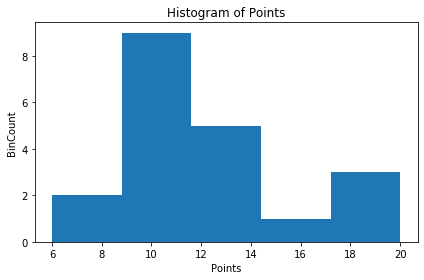

In [17]:
points_for_histogram=sorted([int(literal_eval(row.points)) for row in df_with_updated_points.select(col('points')).collect()])
print(points_for_histogram)
fig, ax = plt.subplots()
num_bins = 5

ax.hist(points_for_histogram, num_bins)
ax.set_xlabel('Points')
ax.set_ylabel('BinCount')
ax.set_title(r'Histogram of Points')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [18]:
sc.stop()